# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

In [1]:
# выведем необходимые библиотеки для работы
import warnings
import datetime


import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

RANDOM_STATE = 12345



In [2]:
# выводим информацию о данных датафреймов с преобразованием столбцов дат к правильному формату

# df1 - датафрейм с данными для обучения модели
df1 = pd.read_csv(
    '/datasets/hotel_train.csv', parse_dates={
        'arrival_date':['arrival_date_year','arrival_date_month','arrival_date_day_of_month']})
# достаточно информации о дате заезда, удалим неделю заезда и наведем порядок в столбцах
df1.drop(columns = ['arrival_date_week_number'], axis = 1, inplace=True)
df1 = df1.reindex(
    columns=['id','arrival_date','total_nights','is_canceled','lead_time','reserved_room_type','adults',
             'children','babies','meal','country','stays_in_weekend_nights','stays_in_week_nights', 
             'required_car_parking_spaces','customer_type','distribution_channel',
             'days_in_waiting_list','booking_changes','is_repeated_guest', 
             'previous_bookings_not_canceled','previous_cancellations',
             'total_of_special_requests'])

# df2 - датафрейм с данными для тестирования модели
df2 = pd.read_csv('/datasets/hotel_test.csv', parse_dates={
        'arrival_date':['arrival_date_year','arrival_date_month','arrival_date_day_of_month']})
# достаточно информации о дате заезда, удалим неделю заезда и наведем порядок в столбцах
df2.drop(columns = ['arrival_date_week_number'], axis = 1, inplace=True)
df2 = df2.reindex(
    columns=['id','arrival_date','total_nights','is_canceled','lead_time','reserved_room_type','adults',
             'children','babies','meal','country','stays_in_weekend_nights','stays_in_week_nights', 
             'required_car_parking_spaces','customer_type','distribution_channel',
             'days_in_waiting_list','booking_changes','is_repeated_guest', 
             'previous_bookings_not_canceled','previous_cancellations',
             'total_of_special_requests'])

# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

def info(df): 
    display(df.head())    
    df.info()
    print()

    
for i in [df1, df2]:
    info(i)


,id,arrival_date,total_nights,is_canceled,lead_time,reserved_room_type,adults,children,babies,meal,country,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,customer_type,distribution_channel,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
0,0,2015-07-01,1,0,7.0,A,1.0,0.0,0.0,BB,GBR,0,1,0,Transient,Direct,0,0,0,0,0,0
1,1,2015-07-01,2,0,14.0,A,2.0,0.0,0.0,BB,GBR,0,2,0,Transient,TA/TO,0,0,0,0,0,1
2,2,2015-07-01,2,0,0.0,C,2.0,0.0,0.0,BB,PRT,0,2,0,Transient,Direct,0,0,0,0,0,0
3,3,2015-07-01,2,0,9.0,C,2.0,0.0,0.0,FB,PRT,0,2,0,Transient,Direct,0,0,0,0,0,1
4,4,2015-07-01,3,1,85.0,A,2.0,0.0,0.0,BB,PRT,0,3,0,Transient,TA/TO,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              65229 non-null  int64         
 1   arrival_date                    65229 non-null  datetime64[ns]
 2   total_nights                    65229 non-null  int64         
 3   is_canceled                     65229 non-null  int64         
 4   lead_time                       65229 non-null  float64       
 5   reserved_room_type              65229 non-null  object        
 6   adults                          65229 non-null  float64       
 7   children                        65229 non-null  float64       
 8   babies                          65229 non-null  float64       
 9   meal                            65229 non-null  object        
 10  country                         65229 non-null  object        
 11  st

,id,arrival_date,total_nights,is_canceled,lead_time,reserved_room_type,adults,children,babies,meal,country,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,customer_type,distribution_channel,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
0,6086,2017-01-01,1,1,74.0,A,2.0,0.0,0.0,BB,PRT,1,0,0,Transient,TA/TO,0,0,0,0,0,0
1,6087,2017-01-01,4,1,62.0,A,2.0,0.0,0.0,BB,AUT,2,2,0,Transient,TA/TO,0,0,0,0,0,1
2,6088,2017-01-01,4,1,62.0,A,2.0,0.0,0.0,BB,AUT,2,2,0,Transient,TA/TO,0,0,0,0,0,1
3,6089,2017-01-01,4,1,71.0,A,1.0,0.0,0.0,BB,PRT,2,2,0,Transient,TA/TO,0,0,0,0,0,1
4,6090,2017-01-01,7,1,172.0,A,2.0,0.0,0.0,BB,BEL,2,5,0,Transient,TA/TO,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              32412 non-null  int64         
 1   arrival_date                    32412 non-null  datetime64[ns]
 2   total_nights                    32412 non-null  int64         
 3   is_canceled                     32412 non-null  int64         
 4   lead_time                       32412 non-null  float64       
 5   reserved_room_type              32412 non-null  object        
 6   adults                          32412 non-null  float64       
 7   children                        32412 non-null  float64       
 8   babies                          32412 non-null  float64       
 9   meal                            32412 non-null  object        
 10  country                         32412 non-null  object        
 11  st

#### Вывод

Открыли файлы с данными, данные готовы к исследовательскому анализу и предобработке.

### Шаг 2. Предобработка и исследовательский анализ данных

In [3]:
# выявили отличия в признаках в обучающей и тестовой выборке
display(df1['country'].value_counts().to_frame())
display(df2['country'].value_counts().to_frame())

,country
PRT,28831
FRA,5974
GBR,5109
ESP,4900
DEU,3887
...,...
ZWE,1
ZMB,1
VGB,1
MMR,1


,country
PRT,9887
GBR,3927
FRA,3477
DEU,2378
ESP,1932
...,...
KIR,1
ATA,1
SYC,1
CIV,1


In [4]:
# уберём лишние признаки для правильного масштабирования выборок 
df1 = df1.query(
    'country != ["ARM", "BFA", "MMR", "CYM", "RWA", "ZMB", "BDI", "NAM", "SMR", "BWA", "UGA", "GUY"]')



In [5]:
# проверим количество признаков
display(df1['country'].value_counts().to_frame())
display(df2['country'].value_counts().to_frame())

,country
PRT,28831
FRA,5974
GBR,5109
ESP,4900
DEU,3887
...,...
ZWE,1
ABW,1
IMN,1
MLI,1


,country
PRT,9887
GBR,3927
FRA,3477
DEU,2378
ESP,1932
...,...
KIR,1
ATA,1
SYC,1
CIV,1


При предработке данных проверим данные на соответствие данных подходящему типу данных, наличие явных и неявных дубликатов.

In [6]:
# переведём целочисленные значения столбцов из 'float' в 'int'
columns = ['lead_time', 'adults', 'children', 'babies']

def col(df):
    for j in columns:
        df[j]=df[j].astype('int')

for i in [df1, df2]:
    col(i)   
    
for i in [df1, df2]:
    info(i)


,id,arrival_date,total_nights,is_canceled,lead_time,reserved_room_type,adults,children,babies,meal,country,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,customer_type,distribution_channel,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
0,0,2015-07-01,1,0,7,A,1,0,0,BB,GBR,0,1,0,Transient,Direct,0,0,0,0,0,0
1,1,2015-07-01,2,0,14,A,2,0,0,BB,GBR,0,2,0,Transient,TA/TO,0,0,0,0,0,1
2,2,2015-07-01,2,0,0,C,2,0,0,BB,PRT,0,2,0,Transient,Direct,0,0,0,0,0,0
3,3,2015-07-01,2,0,9,C,2,0,0,FB,PRT,0,2,0,Transient,Direct,0,0,0,0,0,1
4,4,2015-07-01,3,1,85,A,2,0,0,BB,PRT,0,3,0,Transient,TA/TO,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65212 entries, 0 to 65228
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              65212 non-null  int64         
 1   arrival_date                    65212 non-null  datetime64[ns]
 2   total_nights                    65212 non-null  int64         
 3   is_canceled                     65212 non-null  int64         
 4   lead_time                       65212 non-null  int64         
 5   reserved_room_type              65212 non-null  object        
 6   adults                          65212 non-null  int64         
 7   children                        65212 non-null  int64         
 8   babies                          65212 non-null  int64         
 9   meal                            65212 non-null  object        
 10  country                         65212 non-null  object        
 11  st

,id,arrival_date,total_nights,is_canceled,lead_time,reserved_room_type,adults,children,babies,meal,country,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,customer_type,distribution_channel,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
0,6086,2017-01-01,1,1,74,A,2,0,0,BB,PRT,1,0,0,Transient,TA/TO,0,0,0,0,0,0
1,6087,2017-01-01,4,1,62,A,2,0,0,BB,AUT,2,2,0,Transient,TA/TO,0,0,0,0,0,1
2,6088,2017-01-01,4,1,62,A,2,0,0,BB,AUT,2,2,0,Transient,TA/TO,0,0,0,0,0,1
3,6089,2017-01-01,4,1,71,A,1,0,0,BB,PRT,2,2,0,Transient,TA/TO,0,0,0,0,0,1
4,6090,2017-01-01,7,1,172,A,2,0,0,BB,BEL,2,5,0,Transient,TA/TO,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              32412 non-null  int64         
 1   arrival_date                    32412 non-null  datetime64[ns]
 2   total_nights                    32412 non-null  int64         
 3   is_canceled                     32412 non-null  int64         
 4   lead_time                       32412 non-null  int64         
 5   reserved_room_type              32412 non-null  object        
 6   adults                          32412 non-null  int64         
 7   children                        32412 non-null  int64         
 8   babies                          32412 non-null  int64         
 9   meal                            32412 non-null  object        
 10  country                         32412 non-null  object        
 11  st

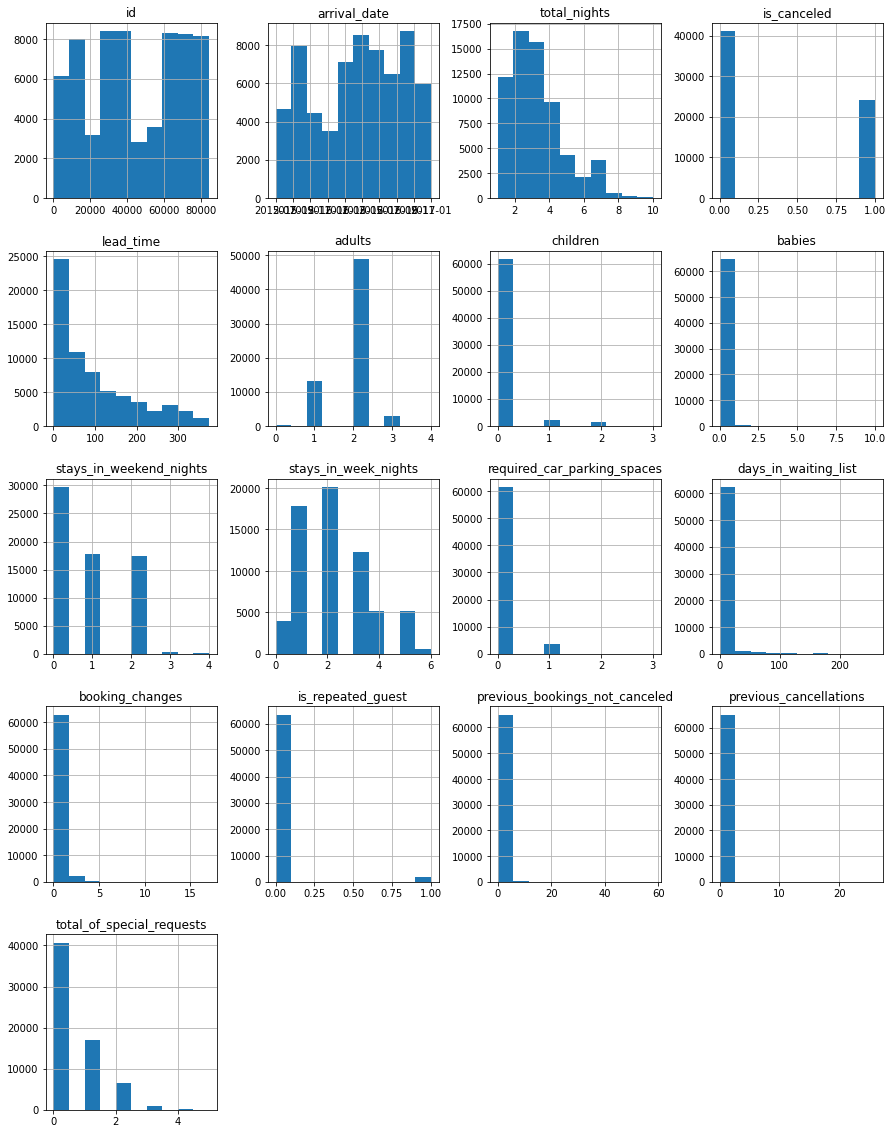

In [7]:
# выведем общие гистограммы для всех числовых столбцов датафрейма для обучения
df1.hist(figsize=(15, 20))
plt.show()

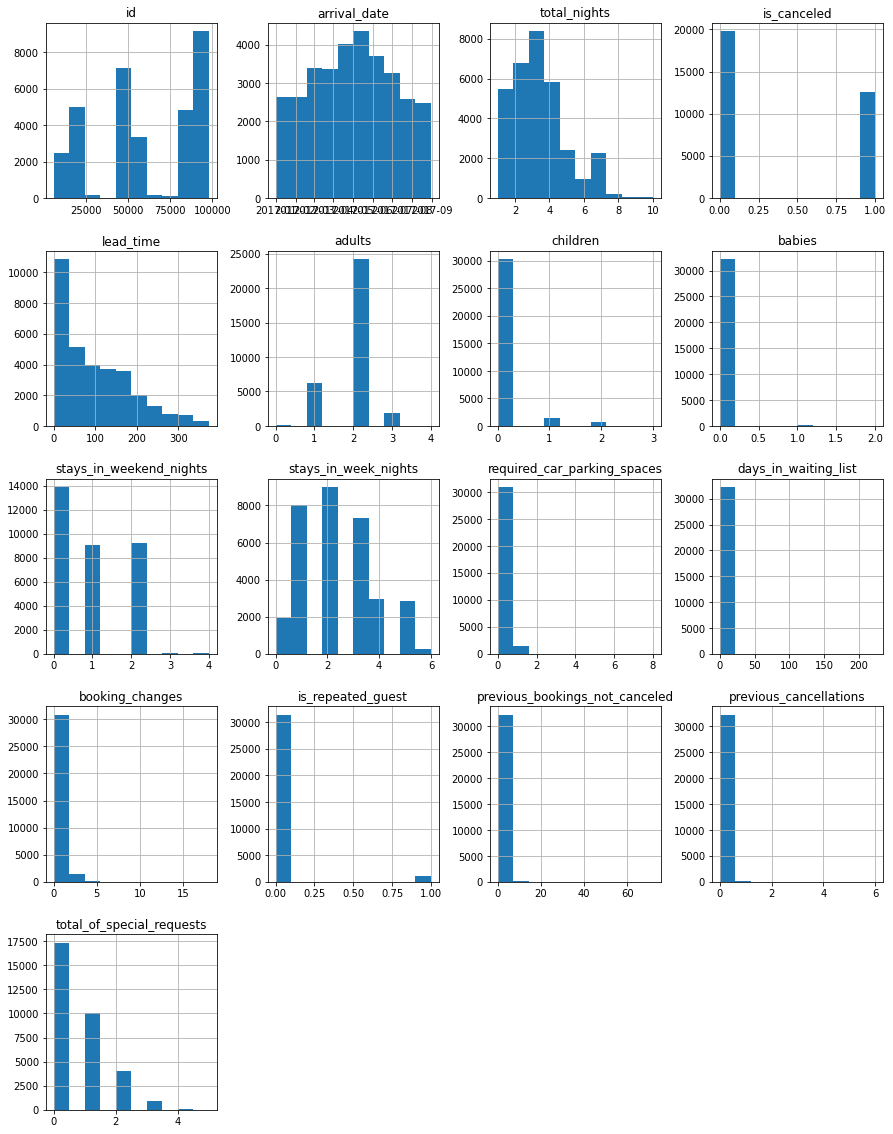

In [8]:
# выведем общие гистограммы для всех числовых столбцов датафрейма для теста
df2.hist(figsize=(15, 20))
plt.show()

In [9]:
# проверим наличие пропусков значений и количества явных дубликатов в данных
def drop_dupl(df):
    display(df.isna().sum())
    print('Количество явных дубликатов:',df.duplicated().sum())
    print()
        
for i in [df1, df2]:
    drop_dupl(i)   

id                                0
arrival_date                      0
total_nights                      0
is_canceled                       0
lead_time                         0
reserved_room_type                0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
stays_in_weekend_nights           0
stays_in_week_nights              0
required_car_parking_spaces       0
customer_type                     0
distribution_channel              0
days_in_waiting_list              0
booking_changes                   0
is_repeated_guest                 0
previous_bookings_not_canceled    0
previous_cancellations            0
total_of_special_requests         0
dtype: int64

Количество явных дубликатов: 0



id                                0
arrival_date                      0
total_nights                      0
is_canceled                       0
lead_time                         0
reserved_room_type                0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
stays_in_weekend_nights           0
stays_in_week_nights              0
required_car_parking_spaces       0
customer_type                     0
distribution_channel              0
days_in_waiting_list              0
booking_changes                   0
is_repeated_guest                 0
previous_bookings_not_canceled    0
previous_cancellations            0
total_of_special_requests         0
dtype: int64

Количество явных дубликатов: 0



В данных отсутствуют дубликаты и пропуски, проверим основные числовые значения столбцов датафреймов.

In [10]:
# выводим числовые значения числовых столбцов датафрейма для обучения 
df1.describe()

,id,total_nights,is_canceled,lead_time,adults,children,babies,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
count,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000,65212.000000
mean,43543.756870,3.050052,0.368659,96.348034,1.836564,0.074894,0.007238,0.825170,2.224882,0.056661,3.335061,0.194243,0.027158,0.107741,0.128949,0.512789
std,25613.944048,1.738183,0.482445,96.134168,0.480279,0.334265,0.098802,0.853518,1.355034,0.232123,18.241851,0.593790,0.162544,1.326810,0.965449,0.752563
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19108.750000,2.000000,0.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40553.500000,3.000000,0.000000,64.000000,2.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67414.250000,4.000000,1.000000,151.000000,2.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,84121.000000,10.000000,1.000000,374.000000,4.000000,3.000000,10.000000,4.000000,6.000000,3.000000,259.000000,17.000000,1.000000,58.000000,26.000000,5.000000


In [11]:
# выводим числовые значения числовых столбцов датафрейма для теста 
df2.describe()

,id,total_nights,is_canceled,lead_time,adults,children,babies,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
count,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,3.207979,0.388467,97.587869,1.858602,0.083765,0.005523,0.867888,2.34009,0.046248,0.262341,0.216741,0.031377,0.171418,0.011601,0.657781
std,29953.586177,1.738683,0.487409,86.507146,0.489341,0.343470,0.075757,0.853394,1.37517,0.219367,4.733027,0.640551,0.174338,1.875170,0.180473,0.834341
min,6086.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45291.750000,2.000000,0.000000,23.000000,2.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53394.500000,3.000000,0.000000,76.000000,2.000000,0.000000,0.000000,1.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,89800.250000,4.000000,1.000000,155.000000,2.000000,0.000000,0.000000,2.000000,3.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,97903.000000,10.000000,1.000000,373.000000,4.000000,3.000000,2.000000,4.000000,6.00000,8.000000,223.000000,18.000000,1.000000,72.000000,6.000000,5.000000


По значениям видно аномальное значение в столбце 'adults' = 0, что теоретически не может быть, дети не могут бронировать и жить без взрослых. Уточним количество подобных записей.

In [12]:
# выведем бронирования без взрослых
display(df1.query('adults == 0'))
print()
display(df2.query('adults == 0'))

,id,arrival_date,total_nights,is_canceled,lead_time,reserved_room_type,adults,children,babies,meal,country,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,customer_type,distribution_channel,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
17540,25480,2015-08-10,2,0,1,B,0,3,0,BB,PRT,1,1,0,Transient-Party,Direct,0,1,0,0,0,0
17598,25538,2015-08-11,3,0,104,B,0,2,0,BB,FRA,0,3,0,Transient-Party,TA/TO,0,1,0,0,0,2
17982,25922,2015-08-16,2,0,3,B,0,2,0,BB,PRT,2,0,0,Transient-Party,Direct,0,1,0,0,0,1
21556,29496,2015-10-19,4,1,48,B,0,2,0,BB,PRT,1,3,0,Transient-Party,TA/TO,0,0,0,0,0,1
22516,30456,2015-12-13,1,1,6,B,0,3,0,BB,PRT,1,0,0,Transient-Party,TA/TO,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64751,83478,2016-12-21,5,0,197,A,0,3,0,HB,FRA,1,4,0,Transient-Party,TA/TO,0,7,0,0,0,0
64882,83610,2016-12-25,3,0,104,B,0,2,0,BB,PRT,2,1,0,Transient,TA/TO,0,1,0,0,0,2
64892,83620,2016-12-25,3,0,104,B,0,2,0,BB,FRA,2,1,0,Transient,TA/TO,0,0,0,0,0,2
64903,83633,2016-12-24,5,0,247,B,0,2,0,BB,PRT,2,3,0,Transient,TA/TO,0,0,0,0,0,1


,id,arrival_date,total_nights,is_canceled,lead_time,reserved_room_type,adults,children,babies,meal,country,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,customer_type,distribution_channel,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
7743,44932,2017-01-02,4,1,111,B,0,2,0,BB,RUS,1,3,0,Transient,TA/TO,0,0,0,0,0,2
7751,44940,2017-01-02,5,1,268,B,0,2,0,BB,RUS,1,4,0,Transient,TA/TO,0,0,0,0,0,1
8772,45961,2017-02-05,7,1,148,B,0,2,0,BB,FRA,2,5,0,Transient,TA/TO,0,0,0,0,0,2
9243,46432,2017-02-22,6,1,134,B,0,2,0,BB,BRA,2,4,0,Transient,TA/TO,0,0,0,0,0,1
9305,46494,2017-02-24,4,1,148,B,0,2,0,BB,BRA,2,2,0,Transient,TA/TO,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30601,96093,2017-07-27,4,0,296,B,0,2,0,BB,GBR,1,3,0,Transient,TA/TO,0,0,0,0,0,1
30654,96146,2017-07-30,3,0,276,B,0,2,0,BB,DEU,2,1,0,Transient,TA/TO,0,1,0,0,0,2
30678,96170,2017-07-29,4,0,291,B,0,2,0,BB,PRT,2,2,0,Transient,TA/TO,0,0,0,0,0,1
30815,96307,2017-07-31,4,0,159,A,0,2,0,SC,FRA,1,3,0,Transient,TA/TO,0,1,0,0,0,1


Подобных данных в датафреймах меньше 0.3%, удалим для чистоты исследования.

In [13]:
# удаляем аномальные данные в датафреймах
df1 = df1.query('adults != 0').reset_index(drop=True)
df2 = df2.query('adults != 0').reset_index(drop=True)

In [14]:
# выведем матрицу корреляций коэффициента Пирсона
display(df1.corr().round(3).head())
display(df2.corr().round(3).head())

,id,total_nights,is_canceled,lead_time,adults,children,babies,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
id,1.000,-0.169,-0.241,0.005,0.007,0.002,-0.024,-0.095,-0.158,-0.114,-0.023,-0.003,0.003,0.017,-0.004,0.124
total_nights,-0.169,1.000,0.001,0.158,0.156,0.031,0.024,0.645,0.877,-0.029,-0.004,0.059,-0.114,-0.051,-0.009,0.112
is_canceled,-0.241,0.001,1.000,0.329,0.044,-0.017,-0.030,-0.014,0.011,-0.187,0.076,-0.143,-0.040,-0.046,0.153,-0.257
lead_time,0.005,0.158,0.329,1.000,0.122,-0.059,-0.024,0.047,0.173,-0.117,0.210,-0.007,-0.089,-0.062,0.143,-0.148
adults,0.007,0.156,0.044,0.122,1.000,0.052,0.021,0.121,0.124,0.012,-0.016,-0.052,-0.161,-0.118,0.002,0.181


,id,total_nights,is_canceled,lead_time,adults,children,babies,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests
id,1.000,-0.125,-0.460,-0.047,0.037,-0.020,-0.012,-0.065,-0.118,-0.128,-0.027,0.023,-0.099,-0.036,-0.018,0.132
total_nights,-0.125,1.000,0.036,0.310,0.168,0.051,0.035,0.627,0.875,-0.052,0.019,0.042,-0.135,-0.072,-0.046,0.049
is_canceled,-0.460,0.036,1.000,0.238,0.079,0.011,-0.039,-0.002,0.047,-0.168,0.018,-0.137,-0.126,-0.065,-0.033,-0.218
lead_time,-0.047,0.310,0.238,1.000,0.196,0.044,0.003,0.164,0.290,-0.097,0.066,0.035,-0.169,-0.090,-0.059,0.029
adults,0.037,0.168,0.079,0.196,1.000,0.038,0.019,0.106,0.147,-0.016,-0.004,-0.059,-0.206,-0.141,-0.104,0.129


Корреляция наблюдается у значений столбца 'is_canceled' со столбцом 'lead_time' и 'total_nights' с 'stays_in_weekend_nights', 'stays_in_week_nights'. Но нас больше конечно интересует первая корреляция, связаная с 'отменой', т.е. 'отмена' коррелирует с количеством дней между датой бронирования и датой прибытия.

#### Вывод

 При предработке данных откорректировали целочисленные значения столбцов из 'float' в 'int', выявили аномальные 0 в столбце 'adults', удалили эти данные. Не выявили наличие явных дубликатов и пропусков в данных. Корреляцией Пирсона выявили зависимости данных. Данные готовы к дальнейшей работе, переходим к следующему шагу.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [15]:
# период исследования
display(df1['arrival_date'].min())
display(df1['arrival_date'].max())

Timestamp('2015-07-01 00:00:00')

Timestamp('2016-12-31 00:00:00')

In [16]:
display(df2['arrival_date'].min())
display(df2['arrival_date'].max())

Timestamp('2017-01-01 00:00:00')

Timestamp('2017-08-31 00:00:00')

In [17]:
# выделяем месяц для фильтра по сезонным коэффицентам
df1['arrival_month'] = pd.DatetimeIndex(df1['arrival_date']).month
df2['arrival_month'] = pd.DatetimeIndex(df2['arrival_date']).month


In [18]:
# удалим, выявленные пробелы в категориях номеров
df1.reserved_room_type = df1.reserved_room_type.str.strip()

In [19]:
#cоздадим отдельный датафрейм с нужными признаками
df_profit = df2[['is_canceled', 'arrival_month', 'reserved_room_type', 'total_nights']]
df_profit.head()



,is_canceled,arrival_month,reserved_room_type,total_nights
0,1,1,A,1
1,1,1,A,4
2,1,1,A,4
3,1,1,A,4
4,1,1,A,7


In [20]:
# добавим к получившейся таблице значения стоимости комнат и обслуживания
room_coast = pd.DataFrame({'reserved_room_type' : [i for i in sorted(df_profit.reserved_room_type.unique())],
                         'price_per_night' : [1000, 800, 600, 550, 500, 450, 350],
                         'service_price' : [400, 350, 350, 150, 150, 150, 150]})
df_profit = df_profit.merge(room_coast, on='reserved_room_type', how='left')


In [21]:
# добавим коэффициенты по сезону
month_koef = pd.DataFrame({'arrival_month' : [i for i in df_profit.arrival_month.unique()],
                          'koef' : [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4]})
df_profit = df_profit.merge(month_koef, on='arrival_month', how='left')
df_profit



,is_canceled,arrival_month,reserved_room_type,total_nights,price_per_night,service_price,koef
0,1,1,A,1,1000,400,1.0
1,1,1,A,4,1000,400,1.0
2,1,1,A,4,1000,400,1.0
3,1,1,A,4,1000,400,1.0
4,1,1,A,7,1000,400,1.0
...,...,...,...,...,...,...,...
32338,0,8,A,6,1000,400,1.4
32339,0,8,A,7,1000,400,1.4
32340,0,8,A,7,1000,400,1.4
32341,0,8,D,7,550,150,1.4


In [22]:
# создаем функцию для рассчета прибыли и убытка в зависимости от отмены брони
def profit(data):
    if data['is_canceled'] == 0:
        income = data['price_per_night'] * data['koef'] * data['total_nights']
        expenses = data['service_price'] * (1 + data['total_nights'] // 2)
    else:
        income = 0
        expenses = data['service_price'] + (data['price_per_night'] * data['koef'])
    profit = income - expenses
    return profit

In [23]:
# применим функцию с добавлением нового столбца 'total_profit' 
df_profit['total_profit'] = df_profit.apply(profit, axis=1)

In [24]:
# выведем общую прибыль на тестовой выборке
display(df_profit)
profit_no_deposite = df_profit['total_profit'].sum()
print('Прибыль на тестовой выборке без депозита составляет:', profit_no_deposite, 'руб.')



,is_canceled,arrival_month,reserved_room_type,total_nights,price_per_night,service_price,koef,total_profit
0,1,1,A,1,1000,400,1.0,-1400.0
1,1,1,A,4,1000,400,1.0,-1400.0
2,1,1,A,4,1000,400,1.0,-1400.0
3,1,1,A,4,1000,400,1.0,-1400.0
4,1,1,A,7,1000,400,1.0,-1400.0
...,...,...,...,...,...,...,...,...
32338,0,8,A,6,1000,400,1.4,6800.0
32339,0,8,A,7,1000,400,1.4,8200.0
32340,0,8,A,7,1000,400,1.4,8200.0
32341,0,8,D,7,550,150,1.4,4790.0


Прибыль на тестовой выборке без депозита составляет: 32510590.0 руб.


#### Вывод 

Общая прибыль 32510590  рублей. На разработку системы прогнозирования заложен бюджет — 400 000 рублей. Для отелей важно предсказать именно тех, кто отменит бронь и взять с таких постояльцев предоплату. Если постоялец всё-таки не отменит бронь, предоплата пойдёт в счёт оплаты. Если постоялец будет предсказан как не отменяющий бронь и предсказание будет неверное, отель понесёт убытки. Поэтому тут для разработки модели стоит ориентироваться на метрику recall, учитывая, что нужно минимизировать убытки.


### Шаг 4. Разработка модели ML

#### Исследуем баланс классов выборки

0    0.631138
1    0.368862
Name: is_canceled, dtype: float64


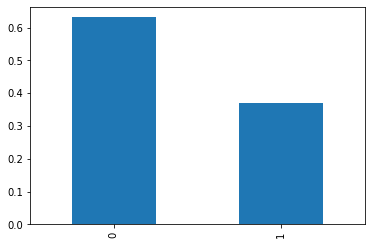

In [26]:
# проверим, как часто в целевом признаке встречается класс «1» или «0»
class_frequency = df1['is_canceled'].value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar')
plt.show()

In [27]:
display(df1)

,id,arrival_date,total_nights,is_canceled,lead_time,reserved_room_type,adults,children,babies,meal,country,stays_in_weekend_nights,stays_in_week_nights,required_car_parking_spaces,customer_type,distribution_channel,days_in_waiting_list,booking_changes,is_repeated_guest,previous_bookings_not_canceled,previous_cancellations,total_of_special_requests,arrival_month
0,0,2015-07-01,1,0,7,A,1,0,0,BB,GBR,0,1,0,Transient,Direct,0,0,0,0,0,0,7
1,1,2015-07-01,2,0,14,A,2,0,0,BB,GBR,0,2,0,Transient,TA/TO,0,0,0,0,0,1,7
2,2,2015-07-01,2,0,0,C,2,0,0,BB,PRT,0,2,0,Transient,Direct,0,0,0,0,0,0,7
3,3,2015-07-01,2,0,9,C,2,0,0,FB,PRT,0,2,0,Transient,Direct,0,0,0,0,0,1,7
4,4,2015-07-01,3,1,85,A,2,0,0,BB,PRT,0,3,0,Transient,TA/TO,0,0,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65041,84057,2016-12-30,6,0,23,D,2,0,0,BB,CHN,2,4,0,Transient,TA/TO,0,0,0,0,0,2,12
65042,84063,2016-12-31,5,0,53,D,2,0,0,HB,FRA,2,3,0,Transient,TA/TO,0,0,0,0,0,3,12
65043,84094,2016-12-31,6,0,7,D,2,0,0,BB,FRA,2,4,0,Transient,TA/TO,0,0,0,0,0,1,12
65044,84117,2016-12-30,7,0,17,A,2,0,0,SC,FRA,2,5,0,Transient,TA/TO,0,0,0,0,0,1,12


In [29]:
# кодируем данные обучающей выборки
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
feature_arr = ohe.fit_transform(
    df1[df1.select_dtypes(include=['object']).columns])

feature_label = ohe.get_feature_names(df1.select_dtypes(include = ['object']).columns)
ohe_train = pd.DataFrame(feature_arr, columns=feature_label)



In [30]:
# кодируем данные тестовой выборки
features_arr = ohe.transform(
    df2[df2.select_dtypes(include=['object']).columns])
ohe_test = pd.DataFrame(features_arr, columns=feature_label)



In [31]:
print('Кол-во строк и столбцов в ohe обучающей выборке:', ohe_train.shape)
print('Кол-во строк и столбцов в ohe тестовой выборке:', ohe_test.shape)

Кол-во строк и столбцов в ohe обучающей выборке: (65046, 163)
Кол-во строк и столбцов в ohe тестовой выборке: (32343, 163)


Соединим закодированные данные с основным массивом и дропнем не кодированные категориальные столбцы:

In [32]:
train = df1[df1.select_dtypes(include=['int','float']).columns]

In [33]:
test = df2[df2.select_dtypes(include=['int','float']).columns]

In [34]:
print('Кол-во строк и столбцов t выборке:', train.shape)
print('Кол-во строк и столбцов m выборке:', test.shape)

Кол-во строк и столбцов t выборке: (65046, 17)
Кол-во строк и столбцов m выборке: (32343, 17)


In [35]:
ohe_train = pd.merge(train, ohe_train, left_index=True, right_index=True)

In [36]:
ohe_test = pd.merge(test, ohe_test, left_index=True, right_index=True)

In [37]:
print('Кол-во строк и столбцов в ohe обучающей выборке:', ohe_train.shape)
print('Кол-во строк и столбцов в ohe тестовой выборке:', ohe_test.shape)

Кол-во строк и столбцов в ohe обучающей выборке: (65046, 180)
Кол-во строк и столбцов в ohe тестовой выборке: (32343, 180)


In [38]:
# извлекаем целевой признак
target_train = ohe_train['is_canceled']

In [39]:
# извлекаем признаки
features_train = ohe_train.drop(['is_canceled'], axis=1)

In [40]:
# выделяем данные для тестовой выборки
features_test, target_test = ohe_test.drop(
    columns='is_canceled', axis=1), ohe_test['is_canceled']


In [41]:
# масштабируем данные 
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

print(features_train.shape)
print(features_test.shape)

(65046, 179)
(32343, 179)


In [42]:
# функция для графиков кроссвалидации чтобы понять, что наши результаты стабильны и не случайны
def cross_val_plot(model, features, target):
    plt.plot(cross_val_score(model, features, target, cv=5, scoring='recall', n_jobs=-1))
    plt.title('Показатели Recall по блокам кроссвалидации')
    plt.xlabel('Блок')
    plt.ylabel('Метрика Recall')
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.show()
    

#### Исследуем recall трёх модели :

##### Логистическая регрессия

In [43]:
# подбираем гиперпарамаметры для модели логической регрессии
parameters = [{'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['l1', 'l2']},
              {'C':[1, 10, 100]}]
grid_search_cv_log = GridSearchCV(
    LogisticRegression(), param_grid = parameters, verbose=0, cv=3, scoring = 'recall')
grid_search_cv_log.fit(features_train, target_train)


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
                         {'penalty': ['l1', 'l2']}, {'C': [1, 10, 100]}],
             scoring='recall')

In [44]:
# выводим модель логистической регрессии с лучшими гиперпараметрами
grid_search_cv_log.best_estimator_

LogisticRegression(solver='liblinear')

In [45]:
# инициализируем модель логистической регрессии
model_logistic = LogisticRegression(solver = 'liblinear')
model_logistic.fit(features_train, target_train)

print('recall для логистической регрессии на кросс-валидации:', cross_val_score(
    model_logistic, features_train, target_train, cv=3, scoring='recall').mean())


recall для логистической регрессии на кросс-валидации: 0.7272191260686665


In [46]:
# выведем наилучшую полноту для модели с заданными параметрами
grid_search_cv_log.best_score_

0.7272191260686665

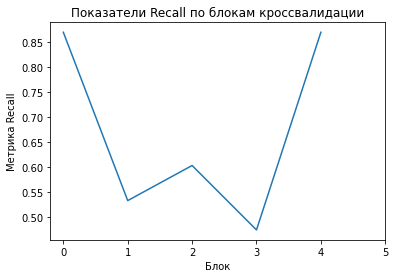

In [47]:
# выводим график кросс-валидации
prediction_logistic = cross_val_plot(model_logistic, features_train, target_train)



##### Дерево решений

In [49]:
# подбираем гиперпарамаметры для модели дерево решений
params = {'max_depth': range (1,20,1),
          'min_samples_leaf': range (1,8)}
grid_search_cv_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE), params, verbose=1, cv=3, scoring = 'recall')
grid_search_cv_tree.fit(features_train, target_train)



Fitting 3 folds for each of 133 candidates, totalling 399 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 20),
                         'min_samples_leaf': range(1, 8)},
             scoring='recall', verbose=1)

In [50]:
# выводим модель дерева решений с лучшими гиперпараметрами
grid_search_cv_tree.best_estimator_


DecisionTreeClassifier(max_depth=1, random_state=12345)

In [51]:
# инициализируем модель дерева решений
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1)
model_tree.fit(features_train, target_train)

print('recall для дерева решений на кросс-валидации:', cross_val_score(
    model_tree, features_train, target_train, cv=3, scoring='recall').mean())



recall для дерева решений на кросс-валидации: 0.6666666666666666


In [52]:
# выведем наилучшую полноту для модели с заданными параметрами
grid_search_cv_tree.best_score_

0.6666666666666666

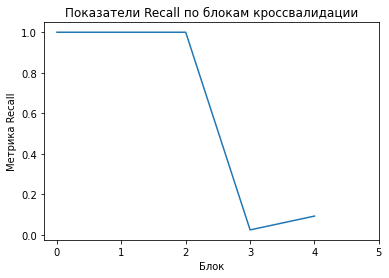

In [53]:
# выводим график кросс-валидации для дерева решений
model_tree = cross_val_plot(model_tree, features_train, target_train)

##### Случайный лес

In [54]:
# подбираем гиперпарамаметры для модели случайного леса
param = {'max_depth': range(1,10,1),
         'n_estimators':range(1,10,1),
          'min_samples_leaf': range (1,8)}
grid_search_cv = GridSearchCV(
     RandomForestClassifier(random_state=RANDOM_STATE), param, verbose=1, cv=3, scoring = 'recall')
grid_search_cv.fit(features_train, target_train)


Fitting 3 folds for each of 567 candidates, totalling 1701 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 8),
                         'n_estimators': range(1, 10)},
             scoring='recall', verbose=1)

In [55]:
# выводим модель случайного леса с лучшими гиперпараметрами
grid_search_cv.best_estimator_


RandomForestClassifier(max_depth=1, n_estimators=1, random_state=12345)

In [56]:
# инициализируем модель случайного леса
model_forest = RandomForestClassifier(n_estimators=1, max_depth=1, random_state=RANDOM_STATE)
model_forest.fit(features_train, target_train)
    
print('recall для случайного леса на кросс-валидации:', cross_val_score(
    model_forest, features_train, target_train, cv=3, scoring='recall').mean())
    


recall для случайного леса на кросс-валидации: 0.6916211984095186


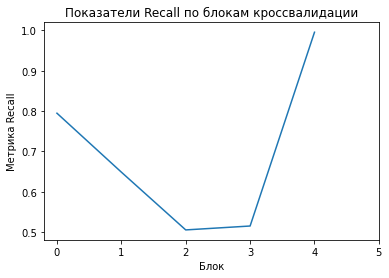

In [57]:
# выводим график кросс-валидации
model_forest = cross_val_plot(model_forest, features_train, target_train)

Лучше всех показала себя модель логистической регрессии recall= 0.7272.

#### Проверим модели на адекватность

In [58]:
# логистическая регрессия

model_logistic = LogisticRegression(solver = 'liblinear')
model_logistic.fit(features_train, target_train)
model_logistic = pd.Series(
    model_logistic.predict(features_test)).value_counts(normalize = True)
print(model_logistic)

0    0.776428
1    0.223572
dtype: float64


#### Борьба с дисбалансом

Дисбаланс попробуем побороть следующим методом. Напрямую укажем о дисбалансе при инициализации модели аргумент class_weight='balanced' и посмотрим, как поменяются значения метрик у исследуюмых моделей.

In [59]:
# дерево решений

model_tree = DecisionTreeClassifier(
    random_state=RANDOM_STATE, max_depth=1, class_weight='balanced')
model_tree.fit(features_train, target_train)

print('recall для дерева решений с аргументом class_weight = balanced на кросс-валидации:', cross_val_score(
    model_tree, features_train, target_train, cv=3, scoring='recall').mean())


recall для дерева решений с аргументом class_weight = balanced на кросс-валидации: 0.6752521463699258


In [60]:
# случайный лес

model_forest = RandomForestClassifier(
    n_estimators=1, max_depth=1, random_state=RANDOM_STATE, class_weight='balanced')
model_forest.fit(features_train, target_train)

print('recall для случайного леса с аргументом class_weight = balanced на кросс-валидации:', cross_val_score(
    model_forest, features_train, target_train, cv=3, scoring='recall').mean())



recall для случайного леса с аргументом class_weight = balanced на кросс-валидации: 0.6916211984095186


In [61]:
# логистическая регрессия

model_logistic = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_logistic.fit(features_train, target_train)

print('recall для логистической регрессии с аргументом class_weight = balanced на кросс-валидации:', cross_val_score(
    model_logistic, features_train, target_train, cv=3, scoring='recall').mean())


recall для логистической регрессии с аргументом class_weight = balanced на кросс-валидации: 0.7997399447815353


По итогу применения аргумента class_weight='balanced' модель **Случайного леса** показала до: 
- Recall для модели случайного лес: 0.6916

после введения аргумента class_weight='balanced':
- Recall для модели случайного лес: 0.6916


**Дерево решений** до:
- Recall для модели дерева решений: 0.6666

после:
- Recall для модели дерева решений: 0.6752


**Логическая регрессия** до:
- Recall для логистической регрессии: 0.7272

после:
- Recall для логистической регрессии: 0.7997

-------------
 В целом модель логической регрессии показывает лучшие значения метрик после применения аргумента class_weight='balanced'. 

 Финальная модель будет выглядеть следующим образом:

In [62]:
model_logistic = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_logistic.fit(features_train, target_train)

print('recall финальной модели логистической регрессии:', cross_val_score(
    model_logistic, features_train, target_train, cv=3, scoring='recall').mean())


recall финальной модели логистической регрессии: 0.7997399447815353


#### Тестирование модели

recall 0.6210191082802548
AUC-ROC 0.9198132943069244


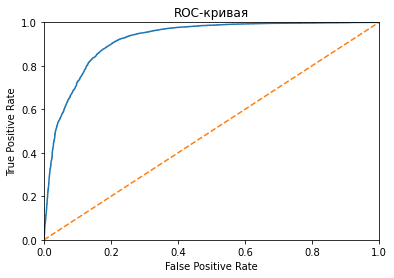

In [63]:
# модель логистической регрессии с лучшей полнотой
model_test = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_test.fit(features_train, target_train)

predicted_test = model_test.predict(features_test)
predicted_one_test = model_test.predict_proba(features_test)[:, 1]

# выведем метрики полноты и метрику, характеризующую качество модели «площадь под ROC-кривой»
print("recall" , recall_score(target_test, predicted_test))
print("AUC-ROC", roc_auc_score(target_test, predicted_one_test))

fpr, tpr, thresholds = roc_curve(target_test, predicted_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()



На тестировании модели получили хорошие метрики полноты и «площади под ROC-кривой».

In [64]:
# оценим качество модели кросс-валидацией
#scores = cross_val_score(model_test, features_test, target_test, cv=5)
#final_score = scores.mean()
#print('Средняя оценка качества модели:', final_score)


In [65]:
# создаем функцию для рассчета прибыли и убытка в зависимости от отмены брони с депозитом
def profit_pred(row, col):
    if row['is_canceled'] == 0:
        income = row['price_per_night'] * row['koef'] * row['total_nights']
        expans = row['service_price'] * (1 + row['total_nights'] // 2)
    elif (row['is_canceled'] == 1) and (row[col] == 0):
        income = 0
        expans = row['service_price'] + (row['price_per_night'] * row['koef'])
    elif (row['is_canceled'] == 1) and (row[col] == 1):
        income = (row['price_per_night'] * row['koef'] * .8) + (row['service_price'] * .8)
        expans = row['service_price'] + (row['price_per_night'] * row['koef'])
    profit_pred = income - expans
    return profit_pred

In [66]:
# добавим столбец с предсказаниями
df_profit['predicted_test'] = model_test.predict(features_test)

In [67]:
# выведем выручку на тестовой выборке после обучения модели дерева решений
df_profit['profit_pred_dt'] = df_profit.apply(profit_pred, col='predicted_test', axis=1)
print('Выручка на тестовой выборке после обучения модели дерева решений:', df_profit['profit_pred_dt'].sum())


Выручка на тестовой выборке после обучения модели дерева решений: 41752070.0


In [68]:
# выведем чистую выручку от внедрения депозитов
print('Модель дерева решений принесёт компании выручку:', df_profit['profit_pred_dt'].sum() - df_profit['total_profit'].sum() - 400000, 'руб')
                                                                                                                                                                                                                            
                                                                                                              

Модель дерева решений принесёт компании выручку: 8841480.0 руб


#### Вывод 

Модель на тестовой выборке показала хорошие результаты

- recall: 0.6210
 
- Оценка качества модели AUC-ROC: 0.9198
  
Модель дерева решений принесёт компании выручку: 8 841 480 руб

### Шаг 5. Опишите портрет «ненадёжного» клиента

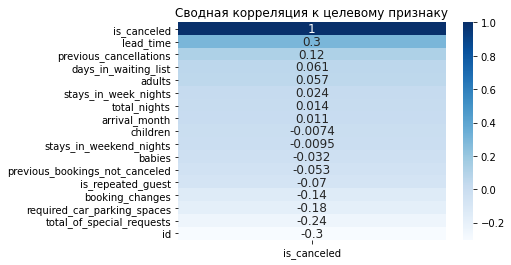

In [69]:
# визуализируем корреляцию между признаками к целевому признаку на обобщенном датафрейме
hotel_concat = pd.concat([df1, df2])
sns.heatmap(hotel_concat.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
                annot = True, annot_kws = {"size":12}, cmap='Blues')
plt.title('Сводная корреляция к целевому признаку')
plt.show()

#### Вывод 

На ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа.
В то же время есть признаки, которые снижают вероятность отмены - долгие взаимоотношения с отелем, наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке и тд. выявляют серьезные намерения у клиента.


### Шаг 6. Напишите общий вывод

При предработке данных откорректировали целочисленные значения столбцов из 'float' в 'int', выявили аномальные 0 в столбце 'adults', удалили эти данные. Не выявили наличие явных дубликатов. Корреляцией Пирсона выявили зависимости  у значений столбца 'is_canceled' со столбцом 'lead_time' и 'total_nights' с 'stays_in_weekend_nights', 'stays_in_week_nights'. 

Общая прибыль без внедрения депозита составила 32510590  рублей. На разработку системы прогнозирования заложен бюджет — 400 000 рублей. Для отелей важно предсказать именно тех, кто отменит бронь и взять с таких постояльцев предоплату. Если постоялец всё-таки не отменит бронь, предоплата пойдёт в счёт оплаты. Если постоялец будет предсказан как не отменяющий бронь и предсказание будет неверное, отель понесёт убытки. Поэтому тут для разработки модели стоит ориентироваться на метрику recall, так как нам было важно не отправить потенциальных отказников в список тех, кто точно не откажется от брони. Ведь именно в этом случае мы потеряем деньги.

Из созданных моделей лучше всего была модель дерева решений, которая  показала хорошие результаты на тестовой выборке:

- recall 0.6210

- AUC-ROC «площадь под ROC-кривой»: 0.9198 

При оценке "ненадежности клиента" влияние сильно оказывает время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа.
В то же время есть признаки, которые снижают вероятность отмены - долгие взаимоотношения с отелем, наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке выявляют серьезные намерения у клиента.
  
Из полученных данных можно сделать вывод, что наивысшее значение recall и наиболее оптимальные параметры у модели Дерева Решений и лучше выбрать именно её. Модель принесёт компании выручку: 8 841 480 рублей, что является целесообразным действием при затратах на разработку системы прогнозирования 400 000 рублей.  
  






  